# Benchmarking a TCR Beta embedder model

## Setup

In [135]:
import os
from pathlib import Path
import sys

if '__project_dir__' not in globals():
    __project_dir__ = Path.cwd().parent.resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [136]:
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from src.datahandling.dataloaders import TCRDataLoader
from src.datahandling.datasets import TCRDataset
from src.datahandling.tokenisers import CDR3Tokeniser
from src import modules
from src import metrics
import torch
from tqdm import tqdm

seaborn.set_theme()
seaborn.set_style('white')

In [137]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

### Load model

In [138]:
model_save_dir = Path('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/model_saves/AutoContrastive_SimCLoss_CDR3BERT_acp')
with open(model_save_dir/'config.json', 'r') as f:
    config = json.load(f)
model = modules.AutoContCDR3BERT_acp(
    contrastive_loss_type='SimCLoss',
    **config['model']['config']
)
model.load_state_dict(torch.load(model_save_dir/'state_dict.pt'))
model.eval()
model.to(device)

# model = modules.AtchleyEmbedder()
# model.to(device)

AutoContCDR3BERT_acp(
  (encoder_stack): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropo

### Create benchmarking directory

In [139]:
BENCHMARK_DIR = Path(f'benchmarks_beta/{model.name}')
if not BENCHMARK_DIR.is_dir():
    BENCHMARK_DIR.mkdir()

### Create cache directory

In [140]:
CACHE_DIR = BENCHMARK_DIR/'.cache'
if not CACHE_DIR.is_dir():
    CACHE_DIR.mkdir()

### Load data

In [142]:
tanno_et_al_test_subset = pd.read_csv('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/tanno/test_beta.csv').iloc[:10000]

back_ds = TCRDataset(
    data=tanno_et_al_test_subset,
    tokeniser=CDR3Tokeniser()
)
back_dl = TCRDataLoader(dataset=back_ds, batch_size=512, shuffle=False)

In [143]:
ep_ds = TCRDataset(
    data='/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/vdjdb/evaluation_beta.csv',
    tokeniser=CDR3Tokeniser()
)
ep_dl = TCRDataLoader(dataset=ep_ds, batch_size=512, shuffle=False)

## Use model to embed TCRs

In [144]:
SAVED_BACK_EMBS = (CACHE_DIR/'back_embs.pt').is_file()
SAVED_EP_EMBS = (CACHE_DIR/'ep_embs.pt').is_file()

In [145]:
if not SAVED_BACK_EMBS:
    with torch.no_grad():
        back_embs = [model.embed(x.to(device)) for x in tqdm(back_dl)]
        back_embs = torch.concat(back_embs)

    torch.save(back_embs.cpu(), CACHE_DIR/'back_embs.pt')

else:
    back_embs = torch.load(CACHE_DIR/'back_embs.pt').to(device)

  0%|          | 0/20 [00:00<?, ?it/s]/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.10/site-packages/torch/nn/modules/transformer.py:276: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:175.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


In [146]:
if not SAVED_EP_EMBS:
    with torch.no_grad():
        ep_embs = [model.embed(x.to(device)) for x in tqdm(ep_dl)]
        ep_embs = torch.concat(ep_embs)

    torch.save(ep_embs.cpu(), CACHE_DIR/'ep_embs.pt')

else:
    ep_embs = torch.load(CACHE_DIR/'ep_embs.pt').to(device)

100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


## Fit a PCA to the background TCR (Tanno et al.) data

In [147]:
pca = PCA()
pca.fit(back_embs)

PCA()

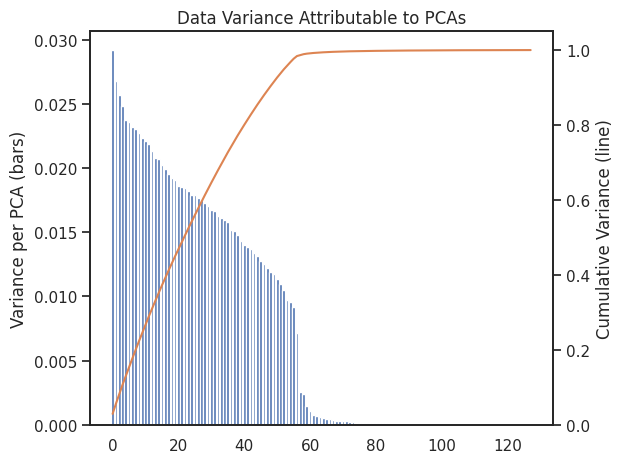

In [148]:
# Display ratios of variance explained by each of the PCAs
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

pca_summary = plt.figure()

ax = plt.axes()
ax.set_title('Data Variance Attributable to PCAs')
ax.set_ylabel('Variance per PCA (bars)')

axd = ax.twinx()
axd.set_ylabel('Cumulative Variance (line)')
axd.set_ylim(0,1.05)

ax.bar(range(pca.n_components_), pca.explained_variance_ratio_)
axd.plot(cumulative_variance, c='C1')

plt.tight_layout()
plt.savefig(BENCHMARK_DIR/'pca.png')
plt.show()

### Visualise TCR distribution in embedding space

In [149]:
background = pca.transform(back_embs)[:,:2]
epitope_labeled = pca.transform(ep_embs)[:,:2]

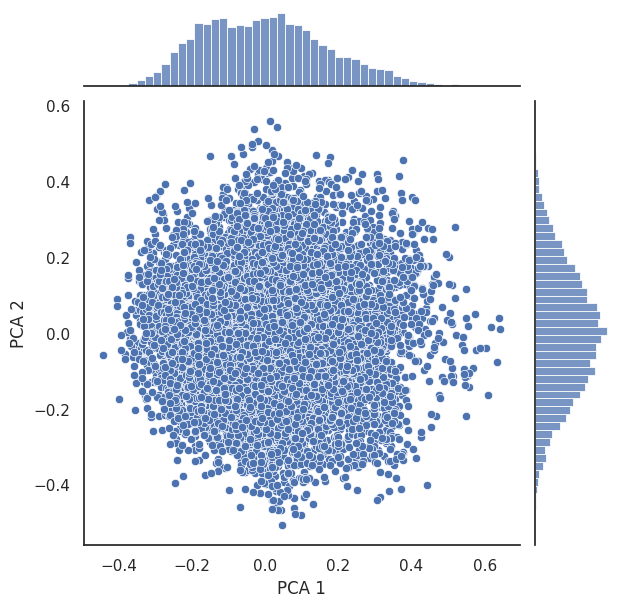

In [150]:
bg_viz = seaborn.jointplot(x=background[:,0], y=background[:,1])

ylim = bg_viz.ax_joint.get_ylim()
xlim = bg_viz.ax_joint.get_xlim()

bg_viz.set_axis_labels(xlabel='PCA 1', ylabel='PCA 2')
bg_viz.savefig(BENCHMARK_DIR/'bg_viz.png')
plt.show()

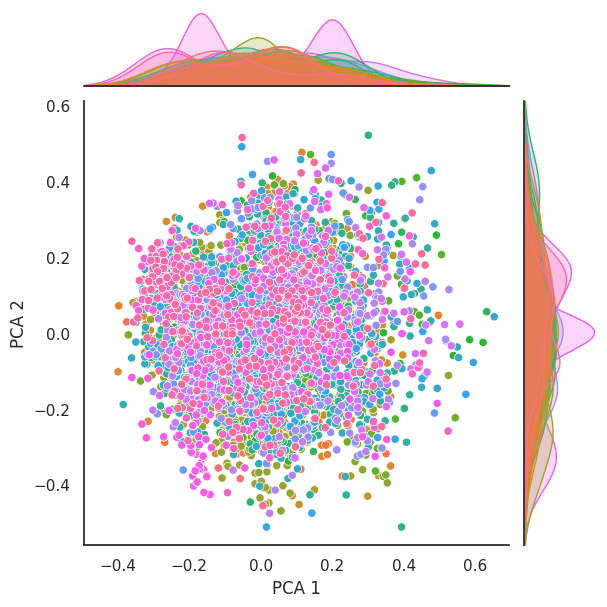

In [151]:
ep_viz = seaborn.jointplot(x=epitope_labeled[:,0], y=epitope_labeled[:,1], xlim=xlim, ylim=ylim, hue=ep_ds._data['Epitope'], legend=False)
ep_viz.set_axis_labels(xlabel='PCA 1', ylabel='PCA 2')
ep_viz.savefig(BENCHMARK_DIR/'ep_viz.png')
plt.show()

## Calculate alignment and uniformity

In [152]:
epitope_cat_codes = torch.tensor(ep_ds._data['Epitope'].astype('category').cat.codes)

In [153]:
alignment = metrics.alignment(ep_embs, epitope_cat_codes).item()

In [154]:
uniformity = metrics.uniformity(ep_embs).item()

## k-NN evaluation

In [162]:
if (CACHE_DIR/'ep_cdist.pt').is_file():
    ep_cdist = torch.load(CACHE_DIR/'ep_cdist.pt').to(device)
else:
    ep_cdist = torch.cdist(ep_embs, ep_embs, p=2)
    torch.save(ep_cdist.cpu(), CACHE_DIR/'ep_cdist.pt')

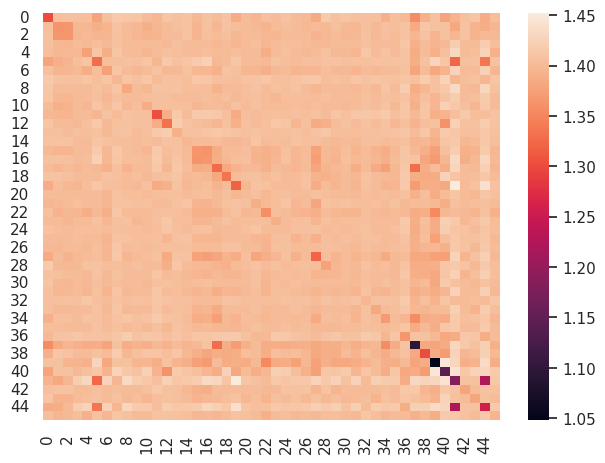

In [156]:
avg_dist_in_group = torch.nn.functional.avg_pool2d(ep_cdist.unsqueeze(0),100).squeeze(0)
scaling_factor = torch.ones(46,46).fill_diagonal_(100/99)
avg_dist_in_group *= scaling_factor

c_dist_map = seaborn.heatmap(avg_dist_in_group)
plt.tight_layout()
plt.savefig(BENCHMARK_DIR/'cdists.png')
plt.show()

In [157]:
ep_cdist.fill_diagonal_(torch.inf)

tensor([[   inf, 1.3252, 1.5029,  ..., 1.4479, 1.4179, 1.4288],
        [1.3252,    inf, 1.4394,  ..., 1.5411, 1.3729, 1.5195],
        [1.5029, 1.4394,    inf,  ..., 1.5707, 1.5027, 1.5353],
        ...,
        [1.4479, 1.5411, 1.5707,  ...,    inf, 1.3386, 1.5129],
        [1.4179, 1.3729, 1.5027,  ..., 1.3386,    inf, 1.4293],
        [1.4288, 1.5195, 1.5353,  ..., 1.5129, 1.4293,    inf]])

In [158]:
knn_scores = dict()

for k in (5, 10, 50, 100):
    scores = []
    ep_size = len(ep_embs)

    for tcr_index in tqdm(range(ep_size)):
        # Get correct epitope label
        expected = epitope_cat_codes[tcr_index]

        # Get list of distances for that TCR
        dists = ep_cdist[tcr_index]

        # Get indices of nearest neighbours
        _, idcs = torch.topk(dists, k=k, largest=False)

        # Get epitopes of nearest neighbours
        knn_cat_codes = epitope_cat_codes[idcs]

        # Predict epitope
        pred, _ = torch.mode(knn_cat_codes)

        # Record score
        scores.append(expected.item() == pred.item())

    score = torch.tensor(scores, dtype=torch.float32).mean().item()

    print(f'{k}-NN score: {score}')

    knn_scores[k] = score

100%|██████████| 4600/4600 [00:00<00:00, 39247.34it/s]


5-NN score: 0.29608696699142456


100%|██████████| 4600/4600 [00:00<00:00, 34145.17it/s]


10-NN score: 0.2956521809101105


100%|██████████| 4600/4600 [00:00<00:00, 23930.14it/s]


50-NN score: 0.2563043534755707


100%|██████████| 4600/4600 [00:00<00:00, 16456.89it/s]

100-NN score: 0.23586957156658173


## Write out evaluation metrics to json

In [159]:
metrics_dict = {
    'model_name': model.name,
    'alignment': alignment,
    'uniformity': uniformity,
    'knn_scores': knn_scores
}

In [160]:
with open(BENCHMARK_DIR/'metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)